## Train the model using contrastive loss only

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(color_codes=True)
import os
import sys

import transformers
from transformers import AutoModelForImageClassification, AutoConfig, AutoFeatureExtractor
from transformers import DefaultDataCollator, TrainerCallback
from transformers.utils import logging

logging.set_verbosity(transformers.logging.ERROR) 
logging.disable_progress_bar() 

p = os.path.abspath('../')
sys.path.insert(1, p)

from torchvision.io import read_image
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, CenterCrop
import torchvision.transforms as transforms

import evaluate

from transformers import TrainingArguments, Trainer
from src.utils.utils import *
from src.transforms.transforms import Noise
from src.wordnet_ontology.wordnet_ontology import WordnetOntology

import math
import copy

from collections import defaultdict

import random
import torchvision
from torchvision.utils import make_grid

from datasets import Image

from src.contrastive_transformers.datasets import AutoAugmentDataset
from src.contrastive_transformers.trainers import ContrastiveTrainer
from src.contrastive_transformers.losses import SupConLoss
from src.contrastive_transformers.collators import ImageCollator

import os
from datasets import load_dataset

n_excluded_classes = int(556 * 0.05)

seed=7361
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mapping_filename = './data/external/imagenet/LOC_synset_mapping.txt'
wn = WordnetOntology(mapping_filename)

vocab = torch.load('./models/vocab.pt')

## Preparing datasets

In [2]:
sketch = load_dataset("imagenet_sketch", split='train', cache_dir='./cache/')
def get_hclass(x):
    _class = wn.class_for_index[x['label']] 
    return { 
        'label': vocab[wn.hypernym(_class)] 
    }

sketch = sketch.map(get_hclass)

Found cached dataset imagenet_sketch (/mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e)
Loading cached processed dataset at /mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-5250d933f01067b4.arrow


In [5]:
_classes = list(set(sketch['label']))
excluded_classes = [random.choice(_classes) for i in range(n_excluded_classes)]
dt = train_test_split(sketch, excluded_labels=excluded_classes)
train, test = dt['train'], dt['test']

In [6]:
[vocab.get_itos()[_cl] for _cl in excluded_classes]

['n02880546',
 'n02095050',
 'n04474466',
 'n02489589',
 'n02417534',
 'n04202417',
 'n01439121',
 'n01560105',
 'n02489589',
 'n01676755',
 'n02114100',
 'n01776192',
 'n03896103',
 'n03294833',
 'n02773037',
 'n01676755',
 'n04340750',
 'n01495701',
 'n09287968',
 'n04038727',
 'n01914163',
 'n02026059',
 'n02453611',
 'n02083346',
 'n01640846',
 'n04500060',
 'n02415435']

In [7]:
imagenet_classes_folder = './data/external/imagenet/ILSVRC/Data/CLS-LOC/train'

image_labels = [] 
image_paths = []

N_IMAGENET_EXAMPLES = 100
imagenet_classes = sorted(os.listdir(imagenet_classes_folder))
for img_class in imagenet_classes:
    all_imgs = os.listdir(f"{imagenet_classes_folder}/{img_class}/")
    img_names = [random.choice(all_imgs) for _ in range(0, N_IMAGENET_EXAMPLES)]
                              
    image_paths.extend([f"{imagenet_classes_folder}/{img_class}/{name}" for name in img_names])
    image_labels.extend([img_class] * len(img_names))

In [8]:
tr = train.cast_column('image', Image(decode=False))
train_data = pd.concat([
    pd.DataFrame({'image': [p['path'] for p in tr['image']], 'label': tr['label']}), 
    pd.DataFrame({'image': image_paths, 'label': [vocab[wn.hypernym(cl)] for cl in image_labels]})
], axis=0).reset_index(drop=True)
print("Image and class data")
print(train_data)
print()

Image and class data
                                                    image  label
0       ./cache/downloads/extracted/b7724a58d90ea10a91...    119
1       ./cache/downloads/extracted/b7724a58d90ea10a91...    312
2       ./cache/downloads/extracted/b7724a58d90ea10a91...    408
3       ./cache/downloads/extracted/b7724a58d90ea10a91...    165
4       ./cache/downloads/extracted/b7724a58d90ea10a91...     68
...                                                   ...    ...
138265  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138266  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138267  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138268  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138269  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555

[138270 rows x 2 columns]



In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

augment = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomApply([Noise(0.25)], p=0.5),
    CenterCrop(feature_extractor.size),  
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])
transform = Compose([
    transforms.ConvertImageDtype(torch.float),
    CenterCrop(feature_extractor.size),  
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# final huggingface dataset
train = AutoAugmentDataset(train_data['image'], train_data['label'], return_negative=False)
data_collator = ImageCollator(transform, None, augment)

## Train the model

In [11]:
torch.hub.set_dir('../cache')
model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [15]:
cb = StoreLosses()

training_args = TrainingArguments(
    output_dir=f"./models/contrastive-only/run-{seed}",
    num_train_epochs=8,
    learning_rate=2e-4,
    evaluation_strategy='no',
    save_strategy='epoch',
    disable_tqdm=False,
    save_total_limit=1,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=8,
    warmup_steps=200,
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=500,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    fp16=True,
    fp16_opt_level='03',
    report_to="wandb",
    optim="adamw_torch"
)

contrastive_head = nn.Sequential(
    nn.Linear(768, 768 // 2),
    nn.ReLU(),
    nn.Linear(768 // 2, 768 // 4),
    nn.ReLU(),
    nn.Linear(768 // 4, 768 // 8),
)

cl_loss = nn.CrossEntropyLoss()
ct_loss = SupConLoss(0.2)

def loss_adapter(anchor_encodings, 
                 positive_encodings, 
                 negative_encodings, 
                 labels, 
                 negative_labels, 
                 anchor_outputs, positive_outputs, negative_outputs):
    contrastive_loss = (
        ct_loss(anchor_encodings, positive_encodings, labels) + 
        ct_loss(positive_encodings, anchor_encodings, labels)
    )

    return contrastive_loss

trainer = ContrastiveTrainer(
    loss=loss_adapter,
    head=contrastive_head,
    use_negatives=False,
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train,
    tokenizer=feature_extractor,
    callbacks=[cb]
)

trainer.train()

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 138270
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 8
  Total optimization steps = 2160
  Number of trainable parameters = 86389248
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kevindellaschiava. Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

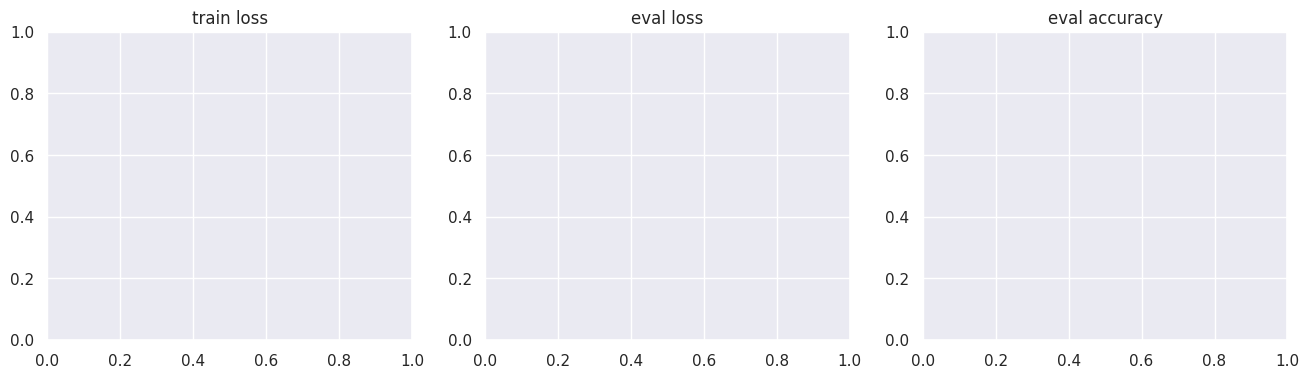

In [16]:
fig = plt.figure(figsize=(16, 4))
ax = plt.GridSpec(1, 3, figure=fig)

class_ax = plt.subplot(ax[0, 0])
contr_ax = plt.subplot(ax[0, 1])
test_ax = plt.subplot(ax[0, 2])

class_ax.set_title("train loss")
contr_ax.set_title("eval loss")
test_ax.set_title("eval accuracy") #classification loss on the test dataset

sns.lineplot(x=range(1, len(cb.train_loss) + 1), y=cb.train_loss, ax=contr_ax)
sns.lineplot(x=range(1, len(cb.eval_loss) + 1), y=cb.eval_loss, ax=class_ax)
sns.lineplot(x=range(1, len(cb.top1) + 1), y=cb.top1, ax=test_ax)

fig.show()